# S(t)

Measure the epoch dependence of the entropy of the NTK.

### Experiment
Perform RND with a model and select N points. Train the model on these N points and use the parameters of the trained model to perform NTK again and see if the points change. Along the way, check the entropy of the updated NTK and see how it has been effected by the training.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


import znrnd as rnd

import tensorflow_datasets as tfds

import numpy as np
import optax
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from neural_tangents import stax

import matplotlib.pyplot as plt

2022-04-29 16:33:03.044414: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
data_generator = rnd.data.MNISTGenerator(ds_size=800)

2022-04-29 16:33:04.359854: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
model = stax.serial(
    stax.Conv(32, (3, 3)),
    stax.Relu(),
    stax.AvgPool(window_shape=(2, 2), strides=(2, 2)),
    stax.Conv(64, (3, 3)),
    stax.Relu(),
    stax.AvgPool(window_shape=(2, 2), strides=(2, 2)),
    stax.Flatten(),
    stax.Dense(256),
    stax.Relu(),
    stax.Dense(10)
)

In [4]:
production_model = rnd.models.NTModel(
        nt_module=model,
        optimizer=optax.adam(learning_rate=0.1),
        loss_fn=rnd.loss_functions.CrossEntropyLoss(classes=10, apply_softmax=False),
        input_shape=(1, 28, 28, 1),
        training_threshold=0.001
    )

In [5]:
train_ds = {
    "inputs": data_generator.ds_train["image"],
    "targets": data_generator.ds_train["label"]
}
test_ds = {
    "inputs": data_generator.ds_test["image"],
    "targets": data_generator.ds_test["label"]
}

In [6]:
entropy_array = []
metrics_array = []
data_subset = data_generator.ds_train["image"][:20]

for _ in range(5):
    ntk = production_model.compute_ntk(
        data_subset, normalize=True
    )["empirical"]
    entropy_array.append(
        rnd.analysis.EntropyAnalysis(ntk).compute_von_neumann_entropy(
            normalize=True
        )
    )
    metrics_array.append(production_model.train_model(
        train_ds=train_ds, test_ds=test_ds, batch_size=32, epochs=1
    ))
    

/home/s/S.Tovey/miniconda3/envs/zincware/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
/home/s/S.Tovey/miniconda3/envs/zincware/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
Epoch: 1: 100%|███████████████████| 1/1 [00:02<00:00,  2.84s/batch, accuracy=0.933, test_loss=0.409]


In [7]:
acc_arr = [item["accuracy"] for item in metrics_array]
loss_arr = [item["loss"] for item in metrics_array]

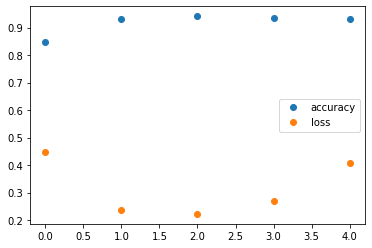

In [14]:
# plt.plot([i for i in range(5)], entropy_array, 'o', label="entropy")
plt.plot([i for i in range(5)], acc_arr, 'o', label="accuracy")
plt.plot([i for i in range(5)], loss_arr, 'o', label="loss")
plt.legend()
plt.show()

In [13]:
acc_arr

[0.8474999666213989,
 0.9312499761581421,
 0.9412499666213989,
 0.9362499713897705,
 0.9325000047683716]